<a href="https://colab.research.google.com/github/MiroDur/MuScat_Miro/blob/master/DataReconstructionRBC5NAc10NAo12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install phantominator
!pip install -U tensorflow-addons

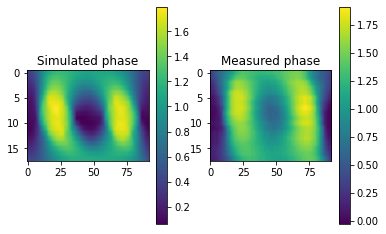

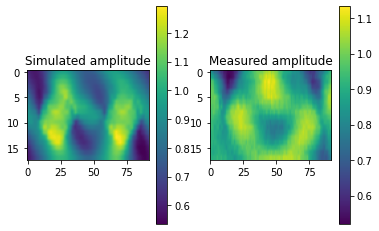

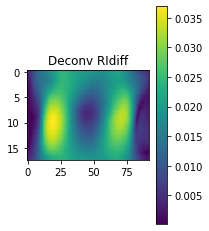

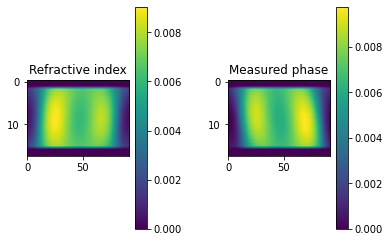

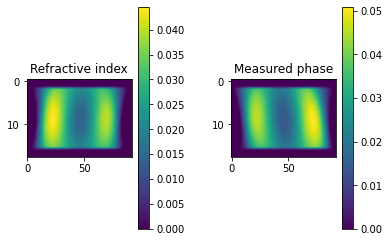

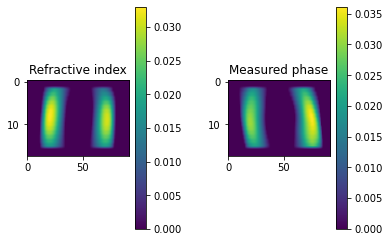

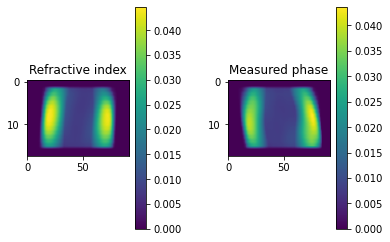

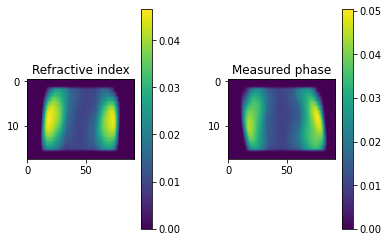

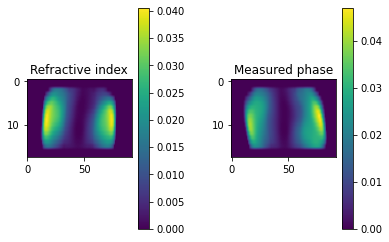

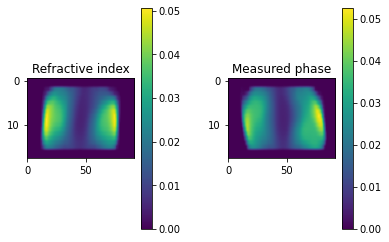

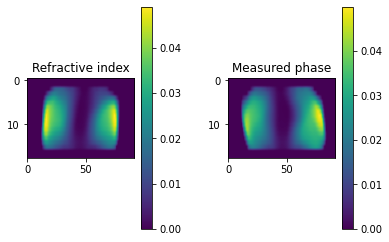

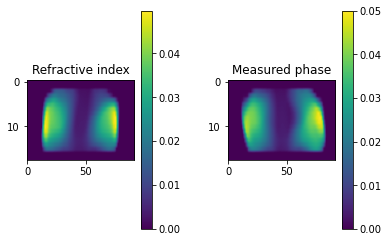

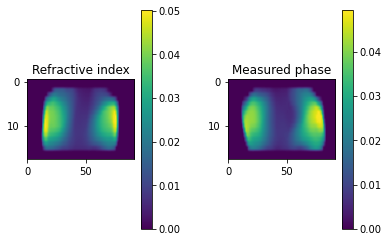

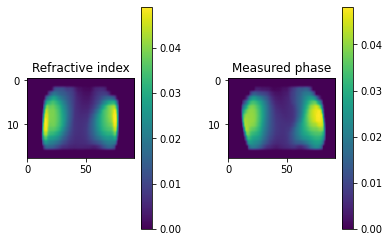

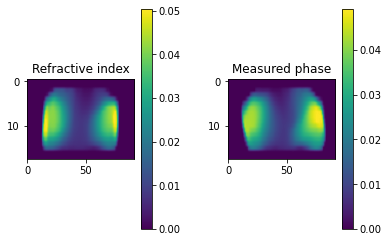

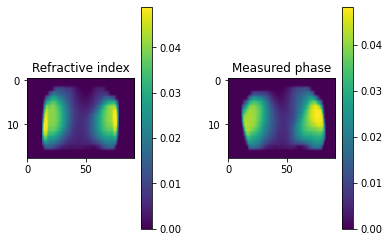

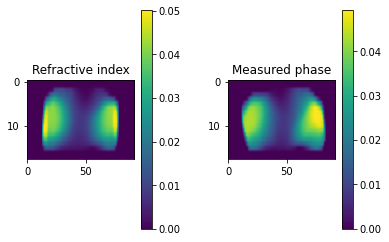

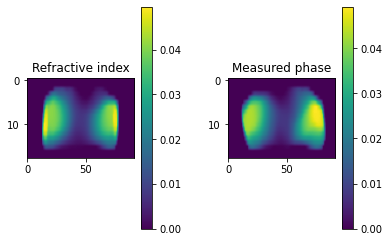

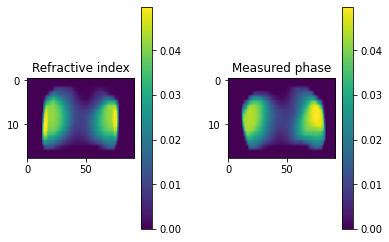

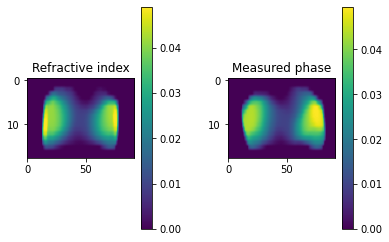

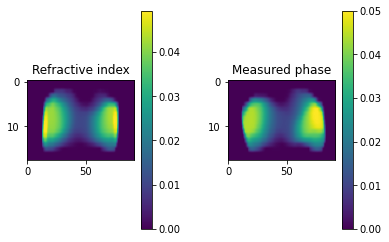

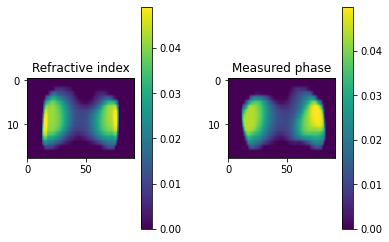

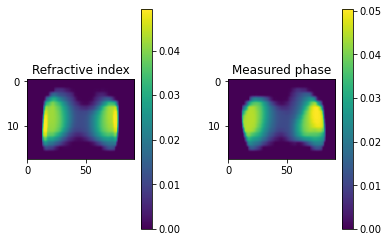

61.18710970878601


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/MuScat')
from MuScatObject import MuScatObject
from MuScatField import MuScatField
from MuScatParameters import MuScatParameters
from MuScatMicroscopeSim import MuScatMicroscopeSim
import tensorflow as tf
import tensorflow_addons as tfa
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io


# %% Load data
start = time.time()
zStackMeasured = np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/RBC2NAc10NAo12.mat')['RBC2_cropped'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/GlassBeadNOA63_NAc09.mat')['BeadNA09e'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/TwoBeadsGlassNOA63.mat')['croppedTwoBeads'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/cell3.mat')['croppedCell3'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/RBC.mat')['croppedRBC'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/GlassBeadNOA63.mat')['croppedBead'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/TwoBeads2.mat')['TwoBeads2'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/GlassPVAFB.mat')['croppedGlassPVAFB1'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/SingleBeadGlassPVA.mat')['croppedSingleBeadGlassE'])

# zStackMeasured *= np.exp(-1j*3)
#zStackMeasured *= 1/5200    # Normalize amplitude (different for each dataset)
# reorder from matlab indexing to python
zStackMeasured = np.transpose(zStackMeasured, [2, 0, 1])
# Data measured with older Q-phase software may be recorded in different order
# therefore some dataset need to be reorded in z direction
zStackMeasured = zStackMeasured[::-1, 14:-14, 14:-14]
# crop dataset
zStackMeasured = zStackMeasured[5:23, :, :]
# z-samplig of the z-Stack measurement = not all measured images have to be used
zsampling = 1
# transversal sampling, applies for simulation as well  
xsampling = 1
zStackMeasured = zStackMeasured[::1, ::xsampling, ::xsampling]
zStckShape = zStackMeasured.shape
zStackMeasured = tf.cast(tf.reshape(tf.constant(zStackMeasured), [1, 
                                                          zStckShape[0], 
                                                          zStckShape[1], 
                                                          zStckShape[2]]),
                         tf.complex64)
centerInd = np.int32(zStckShape[1]/2)
# ==========================================================
# MAKE SURE THAT X AND Y SIZE OF THE GRID FOR SIMULATION IS EVEN!!!
# I probably assumed that in the implementation from the begining
# ==========================================================

# NOA63 glue - refractive index = 1.5559 at 650nm
# soda-lime glass - refractive index = 1.5210 at 650nm - questionable for my spheres
# PVP (gel) - refractive index = 1.5245 at 650nm
# PVA (gel) - refractive index = 1.4757 at 650nm
# water - refractive index = 1.3310 at 650nm

refrIndM = 1.3310

# Illumination in most of the cases with 20x objective with NA=0.5
# Detection with 40x objective NA=0.95
parameters = MuScatParameters(0.650,        # wavelength in vacuum
                              [zStckShape[0]*zsampling, zStckShape[1], zStckShape[2]], # gridSize [z, x ,y]
                              63./600.*xsampling,          # dx
                              63./600.*xsampling,          # dy
                              0.3*refrIndM/zsampling,          # dz
                              refrIndM,          # refractive index in medium
                              1.0,          # NAc
                              1.2)          # NAo
regLambdaL1 = 0.00002
regLambdaL2 = 0.0
regLambdaTV = 0.000006
learnRate = 0.5

imagingSim = MuScatMicroscopeSim(parameters)

# Reference arm objective position can be optimized
refShifts = tf.cast(tf.Variable([[0.08,0.00]],
                                constraint=lambda t: tf.clip_by_value(
                                    t, -0.5, 0.5)), tf.float32)
# refShifts =tf.cast(tf.constant([[0.1,-0.16]]), tf.float32)

# Initialize Illumination and detection part
imagingSim.Illumination(HollowCone=0.0, sampling=1, shift=[8,-2])
imagingSim.Detection()

Piston = 0.   #    1: "Piston",
Xtilt = 0.    #    2: "Tip (lateral position) (X-Tilt)",
Ytilt = 0.    #    3: "Tilt (lateral position) (Y-Tilt)",
Defocus = 0.15  #    4: "Defocus (longitudinal position)",
Oastig = 0.   #    5: "Oblique astigmatism",
Vastig = 0.   #    6: "Vertical astigmatism",
Vcoma =  1.0  #    7: "Vertical coma",
Hcoma = 1.0   #    8: "Horizontal coma",
Vtrefoil = 0. #    9: "Vertical trefoil",
Otrefoil = 0. #    10: "Oblique trefoil",
Spherical = 0.25#    11: "Primary spherical",
#    12: "Vertical secondary astigmatism",
#    13: "Oblique secondary astigmatism",
#    14: "Vertical quadrafoil",
#    15: "Oblique quadrafoil"

zernCoef = tf.Variable([[Piston, Xtilt, Ytilt, Defocus, Oastig, Vastig,
                         Vcoma, Hcoma, Vtrefoil, Otrefoil, Spherical]], tf.float32)
imagingSim.ZernikeCoefficients = zernCoef;
# Initialize object containing refractive index Variable-Tensor to be optimized
optimizedObject = MuScatObject(parameters, initial_value=0., min_value=0.00, max_value=0.08,)

# Define focal positions for z-Stack creation
zPositions = optimizedObject.realzzz[::zsampling,0,0] - optimizedObject.realzzz[0,0,0]
#zPositions = zPositions[4:-6]
# Create object that will be imaged in case of pure simulation
imagedObject = MuScatObject(parameters)
diamSphere = 1.9
posSphere = 2.6
imagedObject.GenerateSphereNP(diamSphere, [-0., 0., posSphere], 1.39)
imagedObject.GenerateSphereNP(diamSphere, [-0., 0., -posSphere], 1.39)
imagedObject.GenerateSphereNP(diamSphere, [-0., -posSphere, -0.], 1.39)
imagedObject.GenerateSphereNP(diamSphere, [-0., posSphere, -0.], 1.39)
imagedObject.GenerateSphereNP(diamSphere, [-0., -2/3*posSphere, -2/3*posSphere], 1.39)
imagedObject.GenerateSphereNP(diamSphere, [-0., 2/3*posSphere, -2/3*posSphere], 1.39)
imagedObject.GenerateSphereNP(diamSphere, [-0., 2/3*posSphere, 2/3*posSphere], 1.39)
imagedObject.GenerateSphereNP(diamSphere, [-0., -2/3*posSphere, 2/3*posSphere], 1.39)

imagingSim.Compute3DCTF(refShifts)
# Simulate light propagation through defined imagedObject
fieldSimulated = MuScatField(imagingSim.planeWaves, parameters).ComputeMuScat(
    imagedObject, method='MLB')

# Generate z-Stack measurement with CCHM from simulated scattered field
zStackSimulated = imagingSim.CCHMImaging(fieldSimulated, zPositions, refShifts) 

# in case of imaging a Bead, check validity of set parameters based on the 
# comparison of simulated and measured data
plt.figure(11)
plt.subplot(121),plt.colorbar(plt.imshow(
    np.angle(zStackSimulated[0, :, :, centerInd]),
    aspect=parameters.dz/parameters.dx))
plt.title('Simulated phase')
plt.subplot(122),plt.colorbar(plt.imshow(
    np.angle(zStackMeasured[0, :, :, centerInd]),
    aspect=parameters.dz/parameters.dx))
plt.title('Measured phase')
plt.figure(12)
plt.subplot(121),plt.colorbar(plt.imshow(
    np.abs(zStackSimulated[0, :, :, centerInd]),
    aspect=parameters.dz/parameters.dx))
plt.title('Simulated amplitude')
plt.subplot(122),plt.colorbar(plt.imshow(
    np.abs(zStackMeasured[0, :, :, centerInd]),
    aspect=parameters.dz/parameters.dx))
plt.title('Measured amplitude')
plt.show()

# in case of Adam or other TF optimizers use this regularizer func. to
# specify L1 and L2 regularization
regularizer = tf.keras.regularizers.L1L2(regLambdaL1, regLambdaL2)
#opt = tf.keras.optimizers.Adam(learning_rate=learnRate)

# Some optimizers such as Yogi have l1 and l2 as parameters
# Yogi is steepest gradient descent based optimizer
# ProximalAdagrad, Yogi
opt = tfa.optimizers.Yogi(learning_rate=learnRate,
                          l1_regularization_strength = regLambdaL1,
                          l2_regularization_strength = regLambdaL2)


regLambdaL1_params = 0.00001
regLambdaL2_params = 0.0001
learnRate_params = 0.1

opt_imagingParams = tfa.optimizers.Yogi(learning_rate=learnRate_params,
                          l1_regularization_strength = regLambdaL1_params,
                          l2_regularization_strength = regLambdaL2_params)


def regTV(variable, parameter):
    diffZ = (variable - tf.roll(variable,1,0))
    diffX = (variable - tf.roll(variable,1,1))
    diffY = (variable - tf.roll(variable,1,2))
    return parameter * tf.reduce_sum(tf.sqrt(diffZ**2 + diffX**2 + diffY**2 + \
                                             tf.keras.backend.epsilon()))


@tf.function
def loss_fn(zStackSimulated, zStackMeasured):
    return tf.reduce_mean(tf.abs(tf.math.angle(zStackMeasured) - tf.math.angle(zStackSimulated))**2) + regTV(optimizedObject.RIDistrib, regLambdaTV)
        #regularizer(optimizedObject.RIDistrib) #+ regTV(optimizedObject.RIDistrib, 0.0005)

RImask = np.zeros(parameters.gridSize)
RImask[2:-2,:,:] = 1.
RImask = tf.constant(RImask, tf.float32)

loss = lambda: loss_fn(imagingSim.CCHMImaging(
    MuScatField(imagingSim.planeWaves, parameters).ComputeMuScat(
        optimizedObject, method='MLB'),
        zPositions,
        refShifts),
        zStackMeasured)
# deconvolution
imagingSim.Compute3DCTF(refShifts)
deconvPot = imagingSim.CCHMdeconvolution(zStackMeasured[0,:,:,:],1e-2)
plt.figure(13)
# assign deconvolved result
#optimizedObject.RIDistrib.assign(deconvPot)

plt.subplot(122),plt.colorbar(plt.imshow(
    np.abs(deconvPot[ :, centerInd, :]),
    aspect=parameters.dz/parameters.dx))
plt.title('Deconv RIdiff')

lossF = [ ]
for i in range(100):
    
    opt_op = opt.minimize(loss, var_list=[optimizedObject.RIDistrib])
    optimizedObject.RIDistrib.assign(optimizedObject.RIDistrib * RImask)
    if i%5==0:
        #for k in range(5):
           # opt_op = opt_imagingParams.minimize(loss, var_list=[refShifts, zernCoef])
        #lossF.append(loss().numpy())
        plt.figure(1)
        plt.subplot(121),plt.colorbar(plt.imshow(
            optimizedObject.RIDistrib[:, centerInd, :],
            aspect=parameters.dz/parameters.dx))
        plt.title('Refractive index')
        plt.subplot(122),plt.colorbar(plt.imshow(
            optimizedObject.RIDistrib[:, :, centerInd],
            aspect=parameters.dz/parameters.dx))
        plt.title('Measured phase')
        plt.tight_layout(pad=3.0)
        #plt.subplot(133),plt.plot(lossF)
        plt.show()

print(time.time()-start)

In [ ]:
np.array(imagedObject.RIDistrib).shape
np.array(imagedObject.RIDistrib)[np.array(((imagedObject.realxxx**2)<1))]
zPositions

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8e87c78090>,
 <matplotlib.colorbar.Colorbar at 0x7f90362de790>)

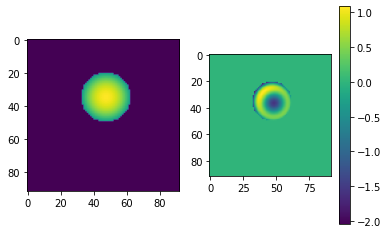

In [ ]:
plt.figure
plt.subplot(121),plt.imshow(np.abs(imagingSim.SPupil[9,:,:]))
plt.subplot(122),plt.colorbar(plt.imshow(np.angle(imagingSim.SPupil[9,:,:])))

Text(0.5, 1.0, 'Deconv RIdiff')

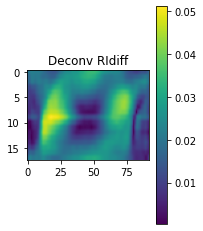

In [ ]:
Piston = 0.   #    1: "Piston",
Xtilt = 0.    #    2: "Tip (lateral position) (X-Tilt)",
Ytilt = 0.    #    3: "Tilt (lateral position) (Y-Tilt)",
Defocus = 0.15  #    4: "Defocus (longitudinal position)",
Oastig = 0.   #    5: "Oblique astigmatism",
Vastig = 0.   #    6: "Vertical astigmatism",
Vcoma =  0.8   #    7: "Vertical coma",
Hcoma = 0.8   #    8: "Horizontal coma",
Vtrefoil = 0. #    9: "Vertical trefoil",
Otrefoil = 0. #    10: "Oblique trefoil",
Spherical = -1.25#    11: "Primary spherical",
#    12: "Vertical secondary astigmatism",
#    13: "Oblique secondary astigmatism",
#    14: "Vertical quadrafoil",
#    15: "Oblique quadrafoil"

zernCoef = tf.Variable([[Piston, Xtilt, Ytilt, Defocus, Oastig, Vastig,
                         Vcoma, Hcoma, Vtrefoil, Otrefoil, Spherical]], tf.float32)
imagingSim.ZernikeCoefficients = -zernCoef
imagingSim.Compute3DCTF(refShifts)
deconvPot = imagingSim.CCHMdeconvolution(zStackMeasured[0,:,:,:],1e-3)
plt.figure(13)

plt.subplot(122),plt.colorbar(plt.imshow(
    np.abs(deconvPot[ :, centerInd, :]),
    aspect=parameters.dz/parameters.dx))
plt.title('Deconv RIdiff')

(54, 54)

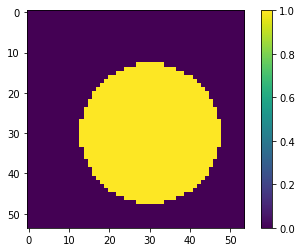

In [ ]:
plt.colorbar(plt.imshow(np.abs(imagingSim.condenserPupilShifted)))
np.abs(imagingSim.condenserPupil).shape

In [ ]:
!pip install pyevtk
from pyevtk.hl import gridToVTK
from pyevtk.hl import imageToVTK
#gridToVTK(
#    "./RIDistrib",
#    imagedObject.realzzz.numpy(),
#    imagedObject.realxxx.numpy(),
#    imagedObject.realyyy.numpy(),
#    pointData={"RIDistrib": optimizedObject.RIDistrib.numpy()},
#    )

imageToVTK(
    "./RIDistribRBCNA10new",
    spacing = (parameters.dz/parameters.dx,1.0,1.0),
    cellData={"RIDistrib": optimizedObject.RIDistrib.numpy()},
    
)


'/content/RIDistribRBCNA10new.vti'

In [ ]:
from scipy.io import savemat
savemat("RBCreconstruct.mat", {"RBCreconstruct": optimizedObject.RIDistrib.numpy()})

In [ ]:
zStckShape

(18, 92, 92)

In [ ]:
RImask = np.zeros(parameters.gridSize)
RImask[10:30,:,:]=1.
plt.imshow(RImask[:,24,:])

In [ ]:
plt.figure(5),plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackSimulated[0, :, centerInd, :]))))))
plt.figure(6),plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackMeasured[0, :, :, centerInd]))))))


refShifts
print(zernCoef)

NameError: ignored

In [ ]:
plt.subplot(121),plt.colorbar(plt.imshow(np.angle(zStackSimulated[0, 12, :, :])))
plt.subplot(122),plt.colorbar(plt.imshow(np.angle(zStackMeasured[0, 12, :, :])))
plt.tight_layout(pad=3.0)

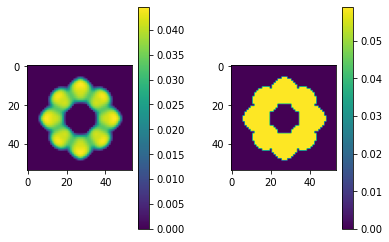

In [ ]:
ind = 10
plt.subplot(121),plt.colorbar(plt.imshow(optimizedObject.RIDistrib[ind, :, :]))
plt.subplot(122),plt.colorbar(plt.imshow(imagedObject.RIDistrib[ind, :, :]))
plt.tight_layout(pad=3.0)

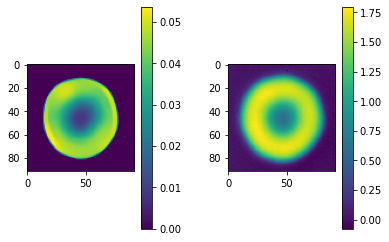

In [ ]:
ind1 =9
plt.subplot(121),plt.colorbar(plt.imshow(optimizedObject.RIDistrib[ind1*zsampling, :, :]))
plt.subplot(122),plt.colorbar(plt.imshow(np.angle(zStackMeasured[0, ind1, :, :])))
plt.tight_layout(pad=3.0)

